# HLA-A allele clustering

In [1]:
from gentype import EnsemblClient, DataManager, PiCollapsedNonparametricGibbsSampler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

import numpy as np

Set up Classes:

In [2]:
Database_Name = "GentypeLCT_DB.db"
client = EnsemblClient()
data_manager = DataManager(client, Database_Name)

Fetch all HLA-A Data obtained in 1000 Genomes project phase3

In [3]:
data_manager.fetch_all(135787850, 135837184, "2")

 COSM1006879


The following generates a inference matrix from the data provided by the local database. The inference matrix can be constructed with respect to a population and a section specified by start and end. Be sure to fetch the according population before constructing the matrix. If _sum_allels = True_ is passed, the expression for an individual per allele will be summed (if expressed on both -> 2, on one -> 1, on neither -> 0). Otherwise each strand will be represented by a seperate row.

In [3]:
inference_matrix, individual_map, variation_map = data_manager.generate_inference_matrix(135787850, 135837184, population = "ALL")
inference_matrix.shape

(5008, 1429)

Mean number of variations per allele, for HLA-A as expected high.

In [4]:
inference_matrix.sum(axis=1).mean()

65.91054313099042

## Model training!
Train final models for different initializations without seeding!

Here we make different models with varying dirichlet prior alpha. This prior is proportional to the probability of creating a new cluster, therefore high alphas tend to begin with a higher number of clusters...

Iteration: 1; Current clusters: 5; Likelihood: -1526855.068
Iteration: 2; Current clusters: 5; Likelihood: -1496111.463
Iteration: 3; Current clusters: 5; Likelihood: -1491740.033
Iteration: 4; Current clusters: 5; Likelihood: -1491604.582
Iteration: 5; Current clusters: 5; Likelihood: -1491591.599
Iteration: 6; Current clusters: 5; Likelihood: -1491688.530
Iteration: 7; Current clusters: 5; Likelihood: -1491509.384
Iteration: 8; Current clusters: 5; Likelihood: -1491557.131
Iteration: 9; Current clusters: 5; Likelihood: -1491484.586
Iteration: 10; Current clusters: 5; Likelihood: -1491496.994
Iteration: 11; Current clusters: 5; Likelihood: -1491742.771
Iteration: 12; Current clusters: 5; Likelihood: -1491598.145
Iteration: 13; Current clusters: 5; Likelihood: -1491635.755
Iteration: 14; Current clusters: 5; Likelihood: -1491665.838
Iteration: 15; Current clusters: 5; Likelihood: -1491714.647
Iteration: 16; Current clusters: 5; Likelihood: -1491672.467
Iteration: 17; Current clusters: 

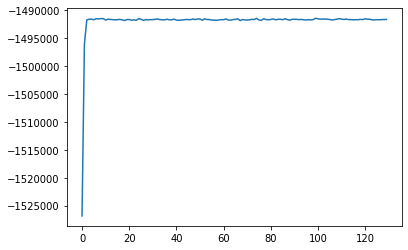

In [5]:
model1 = PiCollapsedNonparametricGibbsSampler(42)
model1.fit(inference_matrix, num_burn_in_steps = 100, delta = 1, alpha = 0.1)
plt.plot(model1.ll_list)

Iteration: 1; Current clusters: 5; Likelihood: -1526937.234
Iteration: 2; Current clusters: 5; Likelihood: -1496257.958
Iteration: 3; Current clusters: 5; Likelihood: -1491753.846
Iteration: 4; Current clusters: 5; Likelihood: -1491695.566
Iteration: 5; Current clusters: 5; Likelihood: -1491631.007
Iteration: 6; Current clusters: 5; Likelihood: -1491865.766
Iteration: 7; Current clusters: 5; Likelihood: -1491719.800
Iteration: 8; Current clusters: 5; Likelihood: -1491560.177
Iteration: 9; Current clusters: 5; Likelihood: -1491815.823
Iteration: 10; Current clusters: 5; Likelihood: -1491612.774
Iteration: 11; Current clusters: 4; Likelihood: -1491736.122
Iteration: 12; Current clusters: 4; Likelihood: -1491663.723
Iteration: 13; Current clusters: 4; Likelihood: -1491537.946
Iteration: 14; Current clusters: 4; Likelihood: -1491664.502
Iteration: 15; Current clusters: 4; Likelihood: -1491650.926
Iteration: 16; Current clusters: 4; Likelihood: -1491697.437
Iteration: 17; Current clusters: 

Iteration: 135; Current clusters: 4; Likelihood: -1491609.651
Iteration: 136; Current clusters: 4; Likelihood: -1491597.664
Iteration: 137; Current clusters: 4; Likelihood: -1491626.196
Iteration: 138; Current clusters: 4; Likelihood: -1491712.887
Iteration: 139; Current clusters: 4; Likelihood: -1491642.412
Iteration: 140; Current clusters: 4; Likelihood: -1491572.487
Iteration: 141; Current clusters: 4; Likelihood: -1491688.692
Iteration: 142; Current clusters: 4; Likelihood: -1491679.794
Iteration: 143; Current clusters: 4; Likelihood: -1491773.032
Iteration: 144; Current clusters: 4; Likelihood: -1491589.784
Iteration: 145; Current clusters: 4; Likelihood: -1491601.835
Iteration: 146; Current clusters: 4; Likelihood: -1491705.970
Iteration: 147; Current clusters: 4; Likelihood: -1491717.879
Iteration: 148; Current clusters: 4; Likelihood: -1491677.834
Iteration: 149; Current clusters: 4; Likelihood: -1491772.996
Iteration: 150; Current clusters: 4; Likelihood: -1491646.909
Iteratio

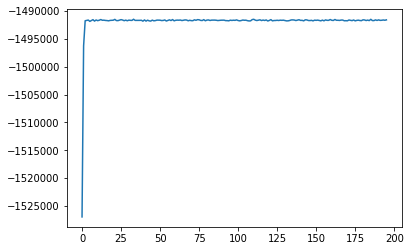

In [6]:
model2 = PiCollapsedNonparametricGibbsSampler(42)
model2.fit(inference_matrix, num_burn_in_steps = 100, delta = 1, alpha = 1)
plt.plot(model2.ll_list)

Iteration: 1; Current clusters: 5; Likelihood: -1532150.735
Iteration: 2; Current clusters: 5; Likelihood: -1512625.333
Iteration: 3; Current clusters: 5; Likelihood: -1495455.777
Iteration: 4; Current clusters: 4; Likelihood: -1493920.318
Iteration: 5; Current clusters: 4; Likelihood: -1493935.616
Iteration: 6; Current clusters: 4; Likelihood: -1494041.531
Iteration: 7; Current clusters: 4; Likelihood: -1493821.979
Iteration: 8; Current clusters: 4; Likelihood: -1494038.160
Iteration: 9; Current clusters: 4; Likelihood: -1493661.872
Iteration: 10; Current clusters: 4; Likelihood: -1493767.635
Iteration: 11; Current clusters: 4; Likelihood: -1493815.781
Iteration: 12; Current clusters: 4; Likelihood: -1493700.451
Iteration: 13; Current clusters: 4; Likelihood: -1493730.800
Iteration: 14; Current clusters: 4; Likelihood: -1493821.340
Iteration: 15; Current clusters: 4; Likelihood: -1493571.904
Iteration: 16; Current clusters: 4; Likelihood: -1493675.859
Iteration: 17; Current clusters: 

Iteration: 135; Current clusters: 4; Likelihood: -1493602.118
Iteration: 136; Current clusters: 4; Likelihood: -1493569.218
Iteration: 137; Current clusters: 4; Likelihood: -1493606.854
Iteration: 138; Current clusters: 4; Likelihood: -1493653.036
Iteration: 139; Current clusters: 4; Likelihood: -1493654.444
Iteration: 140; Current clusters: 4; Likelihood: -1493659.027
Iteration: 141; Current clusters: 4; Likelihood: -1493575.041
Iteration: 142; Current clusters: 4; Likelihood: -1493652.267
Iteration: 143; Current clusters: 5; Likelihood: -1493648.443
Iteration: 144; Current clusters: 4; Likelihood: -1493639.925
Iteration: 145; Current clusters: 4; Likelihood: -1493551.145
Iteration: 146; Current clusters: 4; Likelihood: -1493658.907
Iteration: 147; Current clusters: 6; Likelihood: -1493586.436
Iteration: 148; Current clusters: 4; Likelihood: -1493558.125
Iteration: 149; Current clusters: 4; Likelihood: -1493736.709
Iteration: 150; Current clusters: 4; Likelihood: -1493599.347
Iteratio

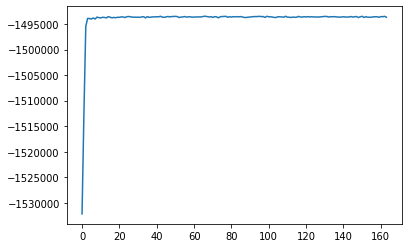

In [7]:
model3 = PiCollapsedNonparametricGibbsSampler(42)
model3.fit(inference_matrix, num_burn_in_steps = 100, delta = 1, alpha = 10)
plt.plot(model3.ll_list)

May pre select models e.g. according to Aitikens Information Criterion (AIC)

In [17]:
models = [model1, model2, model3]


def AIC(model):
    size = np.prod(np.shape(model.theta))
    loglikelihood =model.ll_list[-1]
    return 2*size - 2*loglikelihood

print(list(map(lambda x: AIC(x), models)))

[2994709.8519430263, 2994627.771590854, 2998803.221599189]


## Model validation

In [18]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(inference_matrix)
pca.explained_variance_ratio_.cumsum()

array([0.35828123, 0.61805429])

Over 50% of the variation can be explained by the first two principle components !!!

In [19]:
inds = list(individual_map.keys())
inds.extend(list(individual_map.keys()))

populations = ["AFR", "AMR", "EAS", "EUR", "SAS"]
ind_map = data_manager.generate_individual_population_map()
population_index = []
for ind in inds:
    for pop in ind_map[ind]:
        if pop in populations:
            population_index.append(populations.index(pop))
pops = np.array(population_index)

Population distribution...

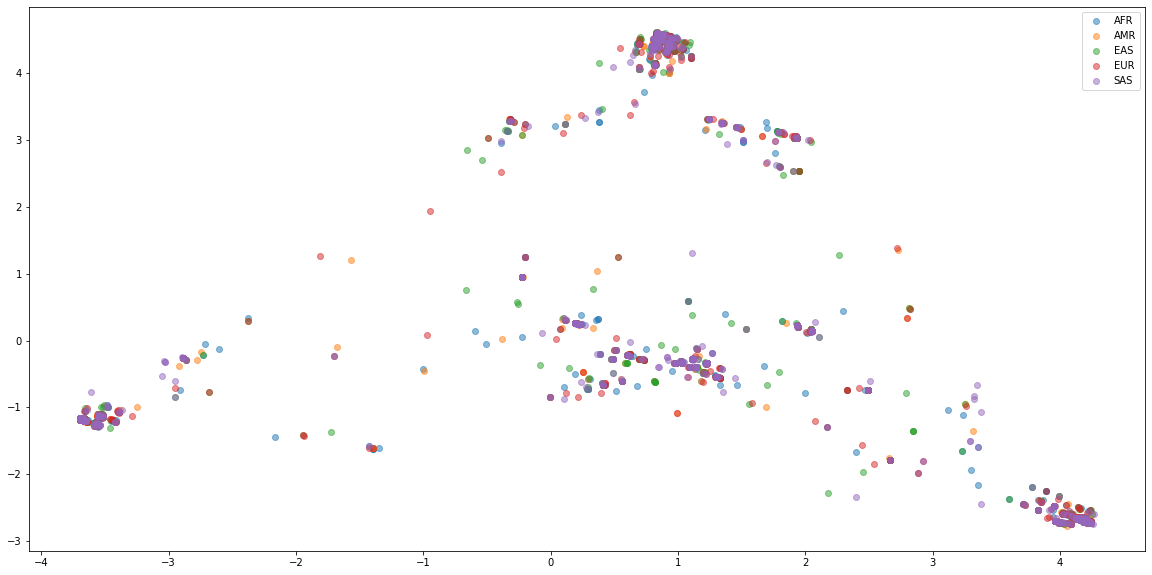

In [20]:
fig, ax = plt.subplots(figsize = (20,10))

for i in range(len(pops)):
    ax.plot(principalComponents[pops == i,0], principalComponents[pops == i,1], "o", alpha=0.5)
ax.legend(populations)

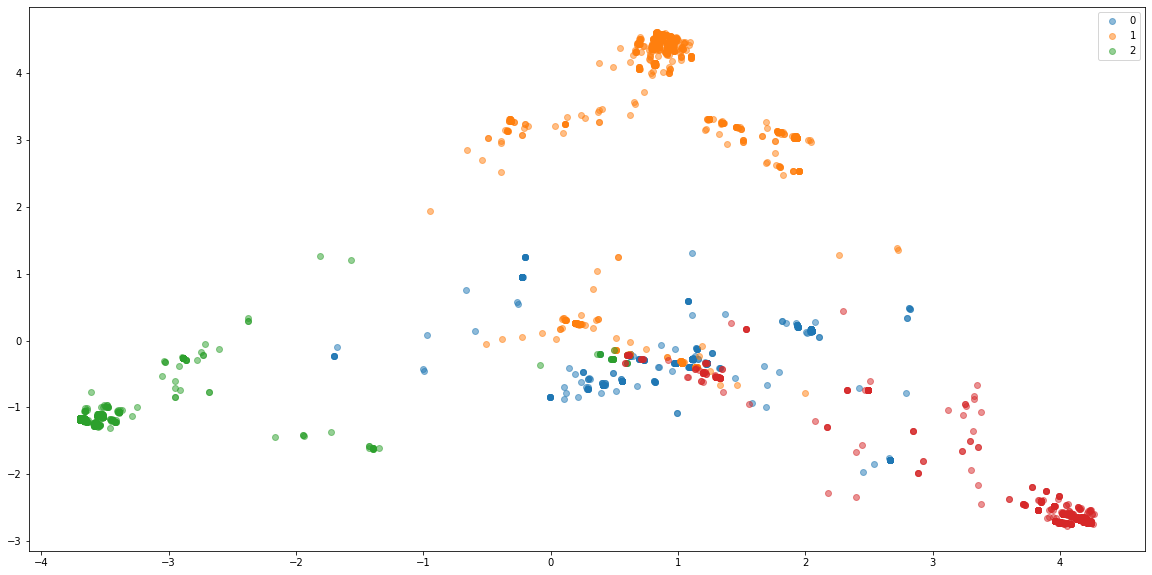

In [22]:
fig, ax = plt.subplots(figsize = (20,10))

for i in range(int(max(model1.Z))+1):
    ax.plot(principalComponents[model1.Z == i,0], principalComponents[model1.Z == i,1], "o", alpha=0.5)
ax.legend(range(int(max(model1.Z))))

In [13]:
df = pd.DataFrame(dict(zip(["Cluster " + str(i) for i in range(len(model1.theta))], list(model1.theta))))

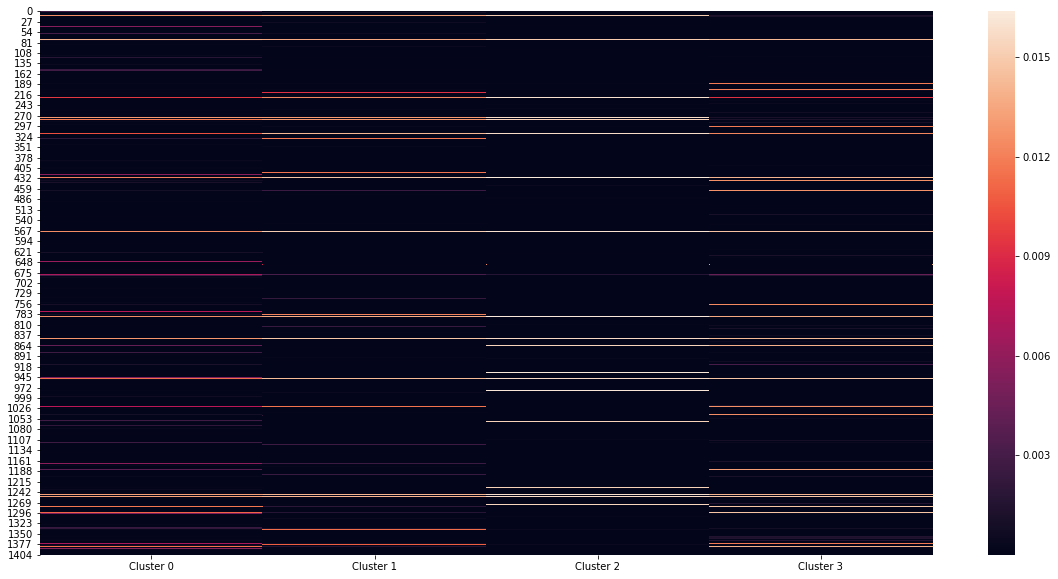

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(df)

The following generates the distribution (as a dict) of amount of variations per strand in the specified region. I.e. {n : #strands with n variations}. And chooses one of the amounts according to the distribution.

In [15]:
distribution = data_manager.get_variation_distribution(start = 17671934, end = 17681934, population = "CHB")
choices = []
probabilities = []
for choice in distribution:
    choices.append(choice)
    probabilities.append(distribution[choice])
choices = np.array(choices)
probabilities = np.array(probabilities) / sum(probabilities)
print("Choices: {}".format(choices))
print("Probabilities: {}".format(probabilities))
np.random.choice(choices, p=probabilities)

Choices: []
Probabilities: []


ValueError: 'a' cannot be empty unless no samples are taken